<a href="https://colab.research.google.com/github/majagurdek/Machine-Learning/blob/main/lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True,
    with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

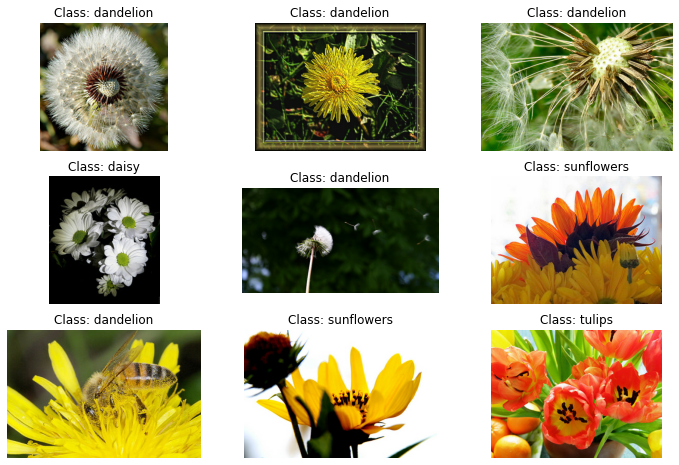

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9)
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show(block=False)

In [ ]:
#Budowanie sieci

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [ ]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

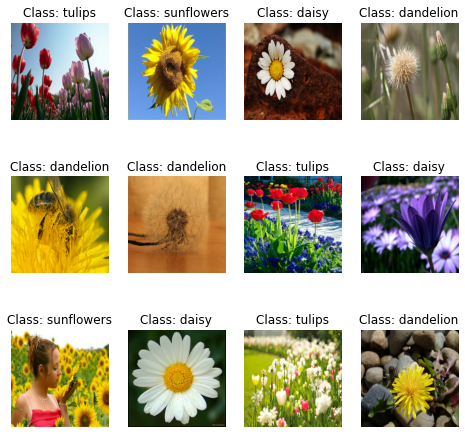

In [ ]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
from tensorflow import keras
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,kernel_size=3, padding="SAME", activation='relu')
model = keras.models.Sequential([
  #qarstwa konwulacyjna
  DefaultConv2D(filters=32, kernel_size=7,input_shape=[224, 224, 3]),
  keras.layers.Rescaling(scale=1./127.5, offset=-1),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=128),
  DefaultConv2D(filters=128),
  keras.layers.MaxPooling2D(pool_size=2),
  DefaultConv2D(filters=256),
  DefaultConv2D(filters=256),
  keras.layers.MaxPooling2D(pool_size=2),
  #warstwa gesta
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units=5, activation='softmax')])

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,validation_data=valid_set,epochs=10)

Epoch 1/10
86/86 [==============================] - 2089s 24s/step - loss: 1.6120 - accuracy: 0.2177 - val_loss: 1.5987 - val_accuracy: 0.3158
Epoch 2/10
86/86 [==============================] - 2012s 23s/step - loss: 1.5968 - accuracy: 0.2482 - val_loss: 1.5557 - val_accuracy: 0.2922
Epoch 3/10
86/86 [==============================] - 1982s 23s/step - loss: 1.5480 - accuracy: 0.2969 - val_loss: 1.4781 - val_accuracy: 0.3430
Epoch 4/10
46/86 [===============>..............] - ETA: 14:32 - loss: 1.5095 - accuracy: 0.3234

In [ ]:
acc_train = model.evaluate(train_set)[1]
acc_valid = model.evaluate(valid_set)[1]
acc_test = model.evaluate(test_set)[1]

In [ ]:
res = (acc_train, acc_valid, acc_test)

In [ ]:
import pickle
with open('simple_cnn_acc.pkl', 'wb') as f:
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

with open('simple_cnn_acc.pkl', 'rb') as f:
    print(pickle.load(f))


In [ ]:
#uczenie transferowe

In [ ]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = tf.keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [ ]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
  for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(X_batch[index] / 2 + 0.5)
    plt.title("Class: {}".format(class_names[y_batch[index]]))
    plt.axis("off")
plt.show()

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",include_top=False)

In [ ]:
for index, layer in enumerate(base_model.layers):
  print(index, layer.name)

In [ ]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)

In [ ]:
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set,epochs=5)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set,epochs=10)

In [ ]:
acc_train2 = model.evaluate(train_set)[1]
acc_valid2 = model.evaluate(valid_set)[1]
acc_test2 = model.evaluate(test_set)[1]

In [ ]:
res2 = (acc_train2, acc_valid2, acc_test2)

In [ ]:
with open('xception_acc.pkl', 'wb') as f:
    pickle.dump(res2, f, pickle.HIGHEST_PROTOCOL)

with open('xception_acc.pkl', 'rb') as f:
    print(pickle.load(f))